Meraj Patel

In [1]:
import numpy as np
import seaborn as sns; sns.set(style="ticks", color_codes=True) 
import sklearn.datasets as datasets
import pandas as pd
import matplotlib.pyplot as plt

# Import train/test dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

datasets = [train, test]

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data Overview

In [2]:
train.shape

(891, 12)

In [3]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [4]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

__Features of interest__: 

Column names pertain to features of interest for our classification problem. We will split features among categorical or numerical, and begin feature extraction below. 

_Categorical_: [Name (title), Sex, Embarked, Pclass]

_Numerical_: [Age, Fare, Parch, SibSp]

Note that we will drop column 'Cabin' given excessive null values

### Feature Extraction - Categorical 

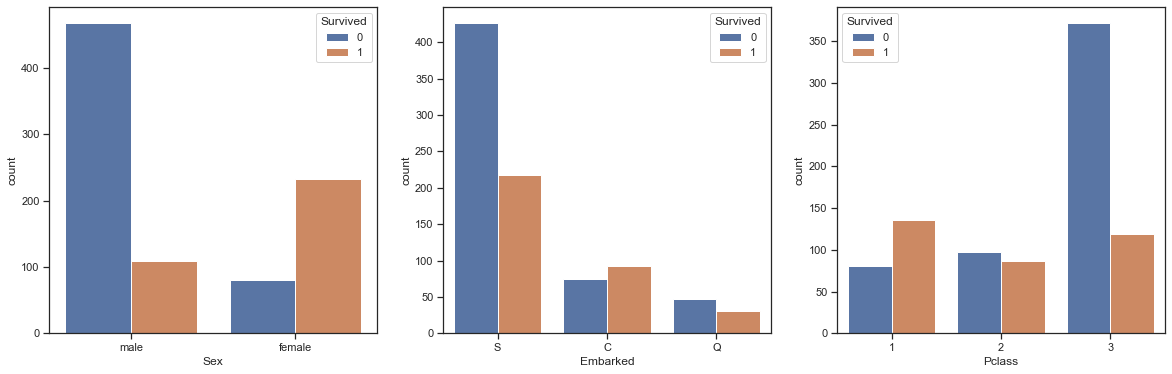

In [5]:
col_cat = ['Sex', 'Embarked','Pclass']
fig, ax = plt.subplots(1,len(col_cat), figsize=(20,6))
for idx, col in enumerate(col_cat):
    sns.countplot(x=col, data=train, ax=ax[idx], hue="Survived")

plt.show()

Above reflects count plots for categorical features - Sex, Embarked, Pclass.
Note that we set 'hue=Survived' to reflect counts of those who survived or perished per feature. The following points are noteworthy:

* More females survived than males
* Individuals who embarked from 'S' are more prone to perish
* Individuals of class 3 are more prone to perish

All three features are essential for determining survival; thus, we will include them in our model. Note that we must impute NA's for the Embarked column on our train and test file as shown below

In [6]:
# Impute Embarked with mode 
for dataset in datasets:
    dataset["Embarked"] = dataset["Embarked"].fillna(dataset["Embarked"].mode()[0])

In [7]:
import re as re 

def title(name):
    result = re.search('([A-Za-z]+)\.', name).group(1)
    if result:
        return result
    return ""

for dataset in datasets:
    dataset['Title'] = dataset['Name'].apply(title)

train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

The above reflects feature analysis for the Name column. Note that incorporating the Full Name within our model will be useless since it serves as a unique ID. Instead, the above code snippet extracts the "title" from each Name. We can see the majority of individuals pertain to "Mr", "Miss", and "Mrs, while the remaining are uncommon. 

Below code snippet creates a Title column to capture each individual's title. If the title is not of "Mr", "Miss" or "Mrs", then replace it with "Misc" 

<AxesSubplot:xlabel='Title', ylabel='count'>

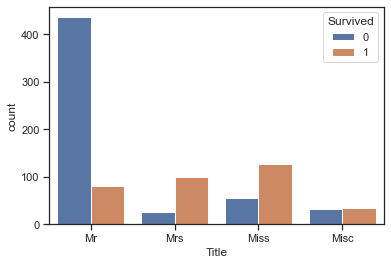

In [8]:
for dataset in datasets:
    dataset['Title'] = dataset['Title'].apply(lambda x: "Misc" if x not in ["Mr","Miss","Mrs"] else x)

sns.countplot(x="Title", data=train, hue="Survived")

Countplot above reflects the distribution of Survival based on our new Title feature. As shown, it is important since those prefixed with "Mr" are more likely to perish. Thus, we will include the Title feature within our final model 

### Feature Extraction - Numerical   

In [9]:
numerical_cols = ["Age", "Fare", "Parch", "SibSp"]
train[numerical_cols].describe()

,Age,Fare,Parch,SibSp
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,32.204208,0.381594,0.523008
std,14.526497,49.693429,0.806057,1.102743
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,7.910400,0.000000,0.000000
50%,28.000000,14.454200,0.000000,0.000000
75%,38.000000,31.000000,0.000000,1.000000
max,80.000000,512.329200,6.000000,8.000000


<AxesSubplot:xlabel='Age', ylabel='count'>

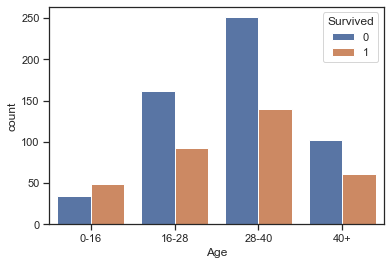

In [10]:
# Impute with random num from: Age mean +- 1std
for dataset in datasets:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    dataset['Age'].fillna(np.random.randint(age_avg - age_std, age_avg + age_std), inplace=True)

def adjust_age(x):
    if x < 16: 
        return "0-16"
    elif  28 > x >= 16:
        return "16-28"
    elif 40 > x >= 28:
        return "28-40"
    elif x >= 40:
        return "40+"

for dataset in datasets:
    dataset['Age'] = dataset["Age"].apply(adjust_age)

sns.countplot(x="Age", data=train, hue="Survived", order=["0-16", "16-28", "28-40", "40+"])

The above code snippet reflects feature extraction for the Age column. First, we impute null Age values by randomly selecting a number between the mean of age plus or minus one standard deviation. Then proceed to categorize age by quantiles - 0-16, 16-28, 28-40, and 40+. The intent is to generalize the feature and reflect survival rates per age group. As shown, individuals in groups 16-28 and 28-40 are associated with lower survival rates.

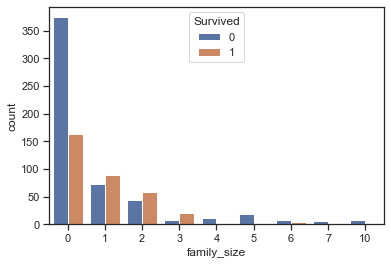

In [11]:
# Anaylsis: Parch + SibSp
family_size = pd.DataFrame().assign(Survived=train.Survived, family_size = train["Parch"] + train["SibSp"])
sns.countplot(x="family_size", data=family_size, hue="Survived")

# Create feature Alone
train["Alone"] = family_size.family_size.map(lambda x: 0 if (x == 0) else 1)
family_size = test["Parch"] + test["SibSp"]
test["Alone"] = family_size.map(lambda x: 0 if (x == 0) else 1)

Above reflects the analysis and feature engineering of columns 'Parch' and 'SibSp'. Parch refers to the number of parents abroad, and Sibsp refers to the number of siblings abroad. We can add both features and store the result in a new column, "family_size" Then, create a count plot to distinguish survival rates depending on family size. As shown, those traveling alone (family_size=0) are more prone to perish. Thus to simplify even further, we created an "Alone" column to indicate if an individual is traveling alone (binary value). We will include this column within our final model and discard "Parch" and "SibSp".

<AxesSubplot:xlabel='Fare', ylabel='count'>

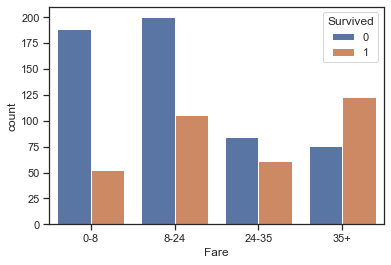

In [12]:
# Anaylsis: Fare
def adjust_fare(x):
    if(x < 8):
        return "0-8"
    elif(24 > x >= 8):
        return "8-24"
    elif(35 > x >= 24):
        return "24-35"
    else:
        return "35+"
    
for dataset in datasets:
    dataset['Fare'] = dataset["Fare"].apply(adjust_fare)
    dataset['Fare'].fillna(dataset["Fare"].mode()[0], inplace=True) # Impute null with mode

sns.countplot(x="Fare", data=train, hue="Survived", order=["0-8", "8-24", "24-35", "35+"])

Our last feature of interest is "Fare". Like age, we further generalize this feature by utilizing quartiles. Specifically, binning individuals per fare groups: 0-8, 8-24, 24-35, and 35+. Based on the count plot, those who paid a cheaper fare are more prone to perish.

### Preprocessing & Model Evaluation

In [13]:
# Ordinal: Fare, pclass
train["Fare"].replace({"0-8":0, "8-24":1, "24-35":2, "35+":3}, inplace=True)
test["Fare"].replace({"0-8":0, "8-24":1, "24-35":2, "35+":3}, inplace=True)

# Nominal: Title, Embarked, Sex, Age
train = pd.get_dummies(train, columns=['Title','Embarked', 'Sex', 'Age'])
test = pd.get_dummies(test, columns=['Title','Embarked', 'Sex', 'Age'])

# Drop columns create train test sets
y_train = np.array(train.Survived)
X_train = np.array(train.drop(columns=["Survived","PassengerId", "Name", "Ticket", "SibSp", "Parch", "Cabin"]))
X_test = np.array(test.drop(columns=["PassengerId", "Name", "Ticket", "SibSp", "Parch", "Cabin"]))

The above reflects preprocessing for our selected features: [Sex, Embarked, Pclass, Title, Age, Fare]

Note that Fare and pclass are ordinal while the remaining are nominal (thus apply one-hot encoding via pd.get_dummies) 

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

def evaluate_model(_model, _X, _y, _niter, text=''):
    accs = []
    kf = StratifiedKFold(n_splits=10, shuffle=False)
    for train_idx, test_idx in kf.split(_X, _y):
        model = _model.fit(_X[train_idx], _y[train_idx])
        y_pred = model.predict(_X[test_idx])
        accs.append(accuracy_score(_y[test_idx], y_pred))
    
    print(f'{text:>20s} Stratified 10-fold CV acc={np.mean(accs):.3f} with {_niter} iterations')

evaluate_model(GaussianNB(), X_train, y_train, 10, 'GaussianNB')  
evaluate_model(RandomForestClassifier(max_depth=None, max_features='auto'), X_train, y_train, 10, 'RandomForestClassifier')  
evaluate_model(SVC(class_weight='balanced', kernel='rbf', gamma=2, C=2), X_train, y_train, 10, 'SVC') 
evaluate_model(DecisionTreeClassifier(), X_train, y_train, 10, 'DecisionTreeClassifier')

          GaussianNB Stratified 10-fold CV acc=0.788 with 10 iterations
RandomForestClassifier Stratified 10-fold CV acc=0.827 with 10 iterations
                 SVC Stratified 10-fold CV acc=0.803 with 10 iterations
DecisionTreeClassifier Stratified 10-fold CV acc=0.819 with 10 iterations


The above snippet evaluates accuracy among four classification models via stratified K fold cross-validation. The RandomForestClassifier yields the highest accuracy; thus, we will use said model for evaluation on the test dataset.

In [15]:
# Random Forest
model = RandomForestClassifier(max_depth=None, max_features='auto')
model.fit(X_train, y_train)
Y_pred = model.predict(X_test)
print(f"RandomForestClassifier Accuracy score on Train: {round(model.score(X_train, y_train) * 100, 2)}%" )

output = pd.DataFrame({'PassengerId': test.PassengerId,
                       'Survived': Y_pred})
output.to_csv('submission.csv', index=False)
print("Kaggle submission score: 0.78229" )

RandomForestClassifier Accuracy score on Train: 87.43%
Kaggle submission score: 0.78229
